In [2]:
import ipdb
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pylab as pylab
import cartopy
import cartopy.crs as ccrs
from utils import constants as cnst
from eod import msg
from utils import u_grid, u_interpolate as u_int, u_darrays as uda, u_arrays as ua
import datetime
import matplotlib.colors as mcolors
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature
from utils import u_plot as uplot
import salem
import numpy.ma as ma
from scipy import stats, ndimage
import warnings
from scipy.ndimage.measurements import label
import pickle as pkl
import matplotlib.patches as patches


pylab.rcParams['figure.figsize'] = (50., 50.)
%matplotlib inline

In [1]:
cd ..

/home/ck/pythonWorkspace/proj_CEH


In [3]:
rtag = ''
vod_n = pkl.load(open('/home/ck/DIR/cornkle/data/HUARAZ/saves/veg_vod_northern_v3'+rtag+'.p', 'rb'))
vod_s = pkl.load(open('/home/ck/DIR/cornkle/data/HUARAZ/saves/veg_vod_southern_v3'+rtag+'.p', 'rb'))
vod_c = pkl.load(open('/home/ck/DIR/cornkle/data/HUARAZ/saves/veg_vod_central_v3'+rtag+'.p', 'rb'))

In [4]:
sm_n = pkl.load(open('/home/ck/DIR/cornkle/data/HUARAZ/saves/veg_sm_northern_v3'+rtag+'.p', 'rb'))
sm_s = pkl.load(open('/home/ck/DIR/cornkle/data/HUARAZ/saves/veg_sm_southern_v3'+rtag+'.p', 'rb'))
sm_c = pkl.load(open('/home/ck/DIR/cornkle/data/HUARAZ/saves/veg_sm_central_v3'+rtag+'.p', 'rb'))

In [5]:
vodcollect = pkl.load(open('/home/ck/DIR/cornkle/data/HUARAZ/saves/climdiff_veg_vodcollect.p', 'rb'))

In [6]:
smcollect = pkl.load(open('/home/ck/DIR/cornkle/data/HUARAZ/saves/climdiff_veg_smcollect.p', 'rb'))

In [7]:
pclim_smw, mclim_smw = pkl.load(open('/home/ck/DIR/cornkle/data/HUARAZ/saves/veg_sm_central_clim.p', 'rb'))

FileNotFoundError: [Errno 2] No such file or directory: '/home/ck/DIR/cornkle/data/HUARAZ/saves/veg_sm_central_clim.p'

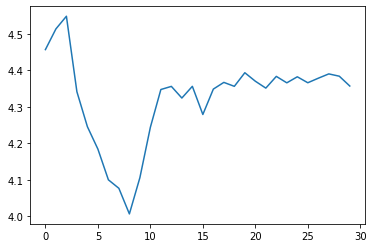

In [8]:
plt.plot(np.nanmean((sm_s['dry7'][8]) / np.nanstd(sm_s['dry7'][8]), axis=0))

In [9]:
np.nanmean(sm_n['dry7'][8])

0.24399148

In [10]:
all_sm = []
for spell in [3,5,7]:
        
    #all_sm.extend(sm_n['wet'+str(spell)][8])
    all_sm.extend(sm_n['dry'+str(spell)][8])
np.nanmean(all_sm)

0.25302497

In [11]:
all_sm = []
for spell in [3,5,7]:
        
    #all_sm.extend(sm_c['wet'+str(spell)][8])
    all_sm.extend(sm_c['dry'+str(spell)][8])
np.nanmean(all_sm)

0.26683718

In [12]:
all_sm = []
for spell in [3,5,7]:
        
    #all_sm.extend(sm_s['wet'+str(spell)][8])
    all_sm.extend(sm_s['dry'+str(spell)][8])
np.nanmean(all_sm)

0.26205784

In [13]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

In [14]:
pww = {'3': [], '5': [], '7': []}

pdd = {'3': [], '5': [], '7': []}

ipos = 0
mv = 1

for vv in [vod_n, vod_c, vod_s]:
    
   # ipdb.set_trace()
    
    for spell in [3,5,7]:
        
        dataw = vv['wet'+str(spell)][ipos]/ vv['wet'+str(spell)][1]
    
        pww[str(spell)].append(dataw-dataw[0])
        
        datad = vv['dry'+str(spell)][ipos]/ vv['dry'+str(spell)][1]
    
        pdd[str(spell)].append(datad-datad[0])

In [15]:
vw = {'3': [], '5': [], '7': []}
vwcorr = {'3': [], '5': [], '7': []}
vwpval = {'3': [], '5': [], '7': []}

vd = {'3': [], '5': [], '7': []}
vdcorr = {'3': [], '5': [], '7': []}
vdpval = {'3': [], '5': [], '7': []}


voddclim = []

ipos = 8
mv = 1

for vv in ([vod_n, vod_c, vod_s]):
    
   # ipdb.set_trace()
    vclimlist = []
    
    for spell in [3,5,7]:
        
        climw = vv['wet'+str(spell)][4] / vv['wet'+str(spell)][6]
        #climw = 0
        
        
        series =  pd.to_datetime((vv['wet'+str(spell)][-1]))
        timepos = np.where(((series.month) >=1 ) | ((series.month) <=14))[0]
        
        dataw = moving_average(np.nanmean((vv['wet'+str(spell)][ipos])[timepos, :],axis=0)-climw,mv)
        
        corr = []
        corrp = []
        for ll in range(len(dataw)):
            
#             a = (vv['wet'+str(spell)][ipos])[:,ll]
#             b = (vv['wet'+str(spell)][ipos])[:,spell]
            
            a = ((vv['wet'+str(spell)][ipos]).T - np.nanmean((vv['wet'+str(spell)][ipos]), axis=1)).T[timepos, ll] #[:,ll]
            b = ((vv['wet'+str(spell)][ipos]).T - np.nanmean((vv['wet'+str(spell)][ipos]), axis=1)).T[timepos, spell+1] #[:,spell]
            
            mask = np.isfinite(a) & np.isfinite(b)
            
            slope, inter, rval, pval, stderr = stats.linregress(a[mask], b[mask])

            corr.append(rval)
            corrp.append(pval)
    
        vw[str(spell)].append((dataw-dataw[0])*-1)  #*-1
        vwcorr[str(spell)].append(np.array(corr))
        vwpval[str(spell)].append(np.array(corrp))
        
        climd = vv['dry'+str(spell)][4] / vv['dry'+str(spell)][6]
        #climd = 0
        
        series = pd.to_datetime((vv['dry'+str(spell)][-1]))
        timepos = np.where(((series.month) >=1) | ((series.month) <=14))[0]
        
        datad = moving_average(np.nanmean((vv['dry'+str(spell)][ipos])[timepos, :],axis=0)-climd,mv)
        
        corr = []
        corrp = []
        for ll in range(len(datad)):
            
#             a = (vv['dry'+str(spell)][ipos])[:,ll]
#             b = (vv['dry'+str(spell)][ipos])[:,spell]
            
            
            a = ((vv['dry'+str(spell)][ipos]).T - np.nanmean((vv['dry'+str(spell)][ipos]), axis=1)).T[timepos, ll] #[:,ll]
            b = ((vv['dry'+str(spell)][ipos]).T - np.nanmean((vv['dry'+str(spell)][ipos]), axis=1)).T[timepos, spell+1] #[:,spell]
            
            mask = np.isfinite(a) & np.isfinite(b)
            
            slope, inter, rval, pval, stderr = stats.linregress(a[mask], b[mask])  
            corr.append(rval)
            corrp.append(pval)
            
    
        vd[str(spell)].append((datad-datad[0])*-1) #*-1
        vdcorr[str(spell)].append(np.array(corr)**2)
        vdpval[str(spell)].append(np.array(corrp))
        
        vclimlist.extend([climw,climd])
        
    voddclim.append(np.median(vclimlist))
        


/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: Mean of empty slice
/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: Mean of empty slice
/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: Mean of empty slice
/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:69: RuntimeWarning: Mean of empty slice
/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: Mean of empty slice
/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: Mean of empty slice
/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: Mean of empty slice
/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:69: RuntimeWarning: Mean of empty slice
/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: Mean of empty slice
/home/ck/m

In [16]:
smw = {'3': [], '5': [], '7': []}
swcorr = {'3': [], '5': [], '7': []}
swpval = {'3': [], '5': [], '7': []}

smd = {'3': [], '5': [], '7': []}
sdcorr = {'3': [], '5': [], '7': []}
sdpval = {'3': [], '5': [], '7': []}

smsclim = []

ipos = 8
mv = 1

for vv, rtag in zip([sm_n, sm_c, sm_s], ['northern', 'central', 'southern']):
    
   # ipdb.set_trace()
    sclimlist = []
    
    for spell in [3,5,7]:
        
        climw = vv['wet'+str(spell)][4] / vv['wet'+str(spell)][6]
        #climw = 0
        
        pclim_smw, mclim_smw = pkl.load(open('/home/ck/DIR/cornkle/data/HUARAZ/saves/veg_sm_'+rtag+'_clim_'+str(spell)+'w.p', 'rb'))
        
        series =  pd.to_datetime((vv['wet'+str(spell)][-1]))
        timepos = np.where(((series.month) >=1) | ((series.month) <=14))[0]
        
        dataw = moving_average(np.nanmean(vv['wet'+str(spell)][ipos],axis=0)-climw,mv)
        
        corr = []
        corrp = []
        for ll in range(len(dataw)):
#             ipdb.set_trace()
#             a = (vv['wet'+str(spell)][ipos])[:,ll]
#             b = (vv['wet'+str(spell)][ipos])[:,spell]
            
            a = ((vv['wet'+str(spell)][ipos]).T - np.nanmean((vv['wet'+str(spell)][ipos]), axis=1))[ll, :] #[:,ll]   ((pclim_smw.T - np.nanmean(pclim_smw, axis=1))[:,0:30000])[iid,:]
            b = ((vv['wet'+str(spell)][ipos]).T - np.nanmean((vv['wet'+str(spell)][ipos]), axis=1)).T[timepos, spell+1] #[:,spell]
            #b = ((pclim_smw.T - np.nanmean(pclim_smw, axis=1)))[ll,:]
     
            mask = np.isfinite(a) & np.isfinite(b)
            
            
            slope, inter, rval, pval, stderr = stats.linregress(a[mask], b[mask])
            
            #rval, pval = stats.ttest_ind(a[np.isfinite(a)], b[np.isfinite(b)], nan_policy='omit', equal_var=False)
            
           # ipdb.set_trace()
            corr.append(rval)
            corrp.append(pval)
    
        smw[str(spell)].append((dataw-dataw[0])*100)
        swcorr[str(spell)].append(np.array(corr)**2)
        swpval[str(spell)].append(np.array(corrp))

        climd = vv['dry'+str(spell)][4] / vv['dry'+str(spell)][6]
        #climd = 0
        
        pclim_smd, mclim_smd = pkl.load(open('/home/ck/DIR/cornkle/data/HUARAZ/saves/veg_sm_'+rtag+'_clim_'+str(spell)+'d.p', 'rb'))
        
        series = pd.to_datetime((vv['dry'+str(spell)][-1]))
        timepos = np.where(((series.month) >=1) | ((series.month) <=14))[0]
        
        datad = moving_average(np.nanmean(vv['dry'+str(spell)][ipos],axis=0)-climd,mv)
        
        corr = []
        corrp = []
        for ll in range(len(datad)):
            
#             a = (vv['dry'+str(spell)][ipos])[:,ll]
#             b = (vv['dry'+str(spell)][ipos])[:,spell]
            
            a = ((vv['dry'+str(spell)][ipos]).T - np.nanmean((vv['dry'+str(spell)][ipos]), axis=1))[ll, :] #[:,ll]
            b = ((vv['dry'+str(spell)][ipos]).T - np.nanmean((vv['dry'+str(spell)][ipos]), axis=1)).T[timepos, spell+1] #[:,spell]
            
            #b = ((pclim_smd.T - np.nanmean(pclim_smd, axis=1)))[ll,:]
            
            mask = np.isfinite(a) & np.isfinite(b)
            
            slope, inter, rval, pval, stderr = stats.linregress(a[mask], b[mask])  
            #rval, pval = stats.ttest_ind(a[np.isfinite(a)], b[np.isfinite(b)], nan_policy='omit', equal_var=False)
            
            corr.append(rval)
            corrp.append(pval)
    
        smd[str(spell)].append((datad-datad[0])*100)
        sdcorr[str(spell)].append(np.array(corr)**2)
        sdpval[str(spell)].append(np.array(corrp))
        
        sclimlist.extend([climw,climd])
        
    smsclim.append(np.median(sclimlist))
        #ipdb.set_trace()


/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: Mean of empty slice
/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: Mean of empty slice
/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:74: RuntimeWarning: Mean of empty slice
/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:75: RuntimeWarning: Mean of empty slice
/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: Mean of empty slice
/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: Mean of empty slice
/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:74: RuntimeWarning: Mean of empty slice
/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:75: RuntimeWarning: Mean of empty slice
/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: Mean of empty slice
/home/ck/m

In [17]:
smsclim

[0.259420934215564, 0.2748884955298358, 0.2695632879036442]

In [18]:
voddclim

[0.6488082581224685, 0.5395836743533595, 0.33039619950618926]

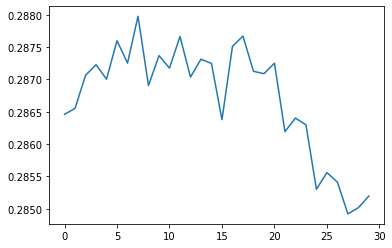

In [19]:
plt.plot(np.nanmean(pclim_smw,axis=0))

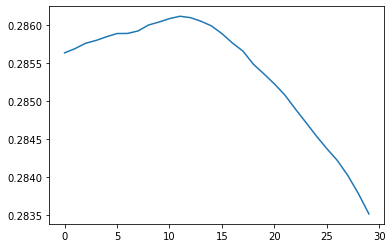

In [20]:
plt.plot(np.nanmean(mclim_smw,axis=0))

/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.
/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: Mean of empty slice
  This is separate from the ipykernel package so we can avoid doing imports until


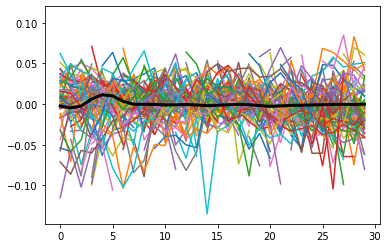

In [21]:
plt.plot((pclim_smw.T - np.nanmean(pclim_smw, axis=1))[:,0:150])
#plt.plot((mclim_smw.T - np.nanmean(mclim_smw, axis=1))[:,0:150])
plt.plot(np.nanmean(((vv['wet3'][ipos]).T - np.nanmean((vv['wet3'][ipos]), axis=1)).T, axis=0), zorder=99, color='k', linewidth=3)


In [22]:
import seaborn as sns
colorw = sns.color_palette("YlGnBu")
colord = sns.color_palette("YlOrBr")

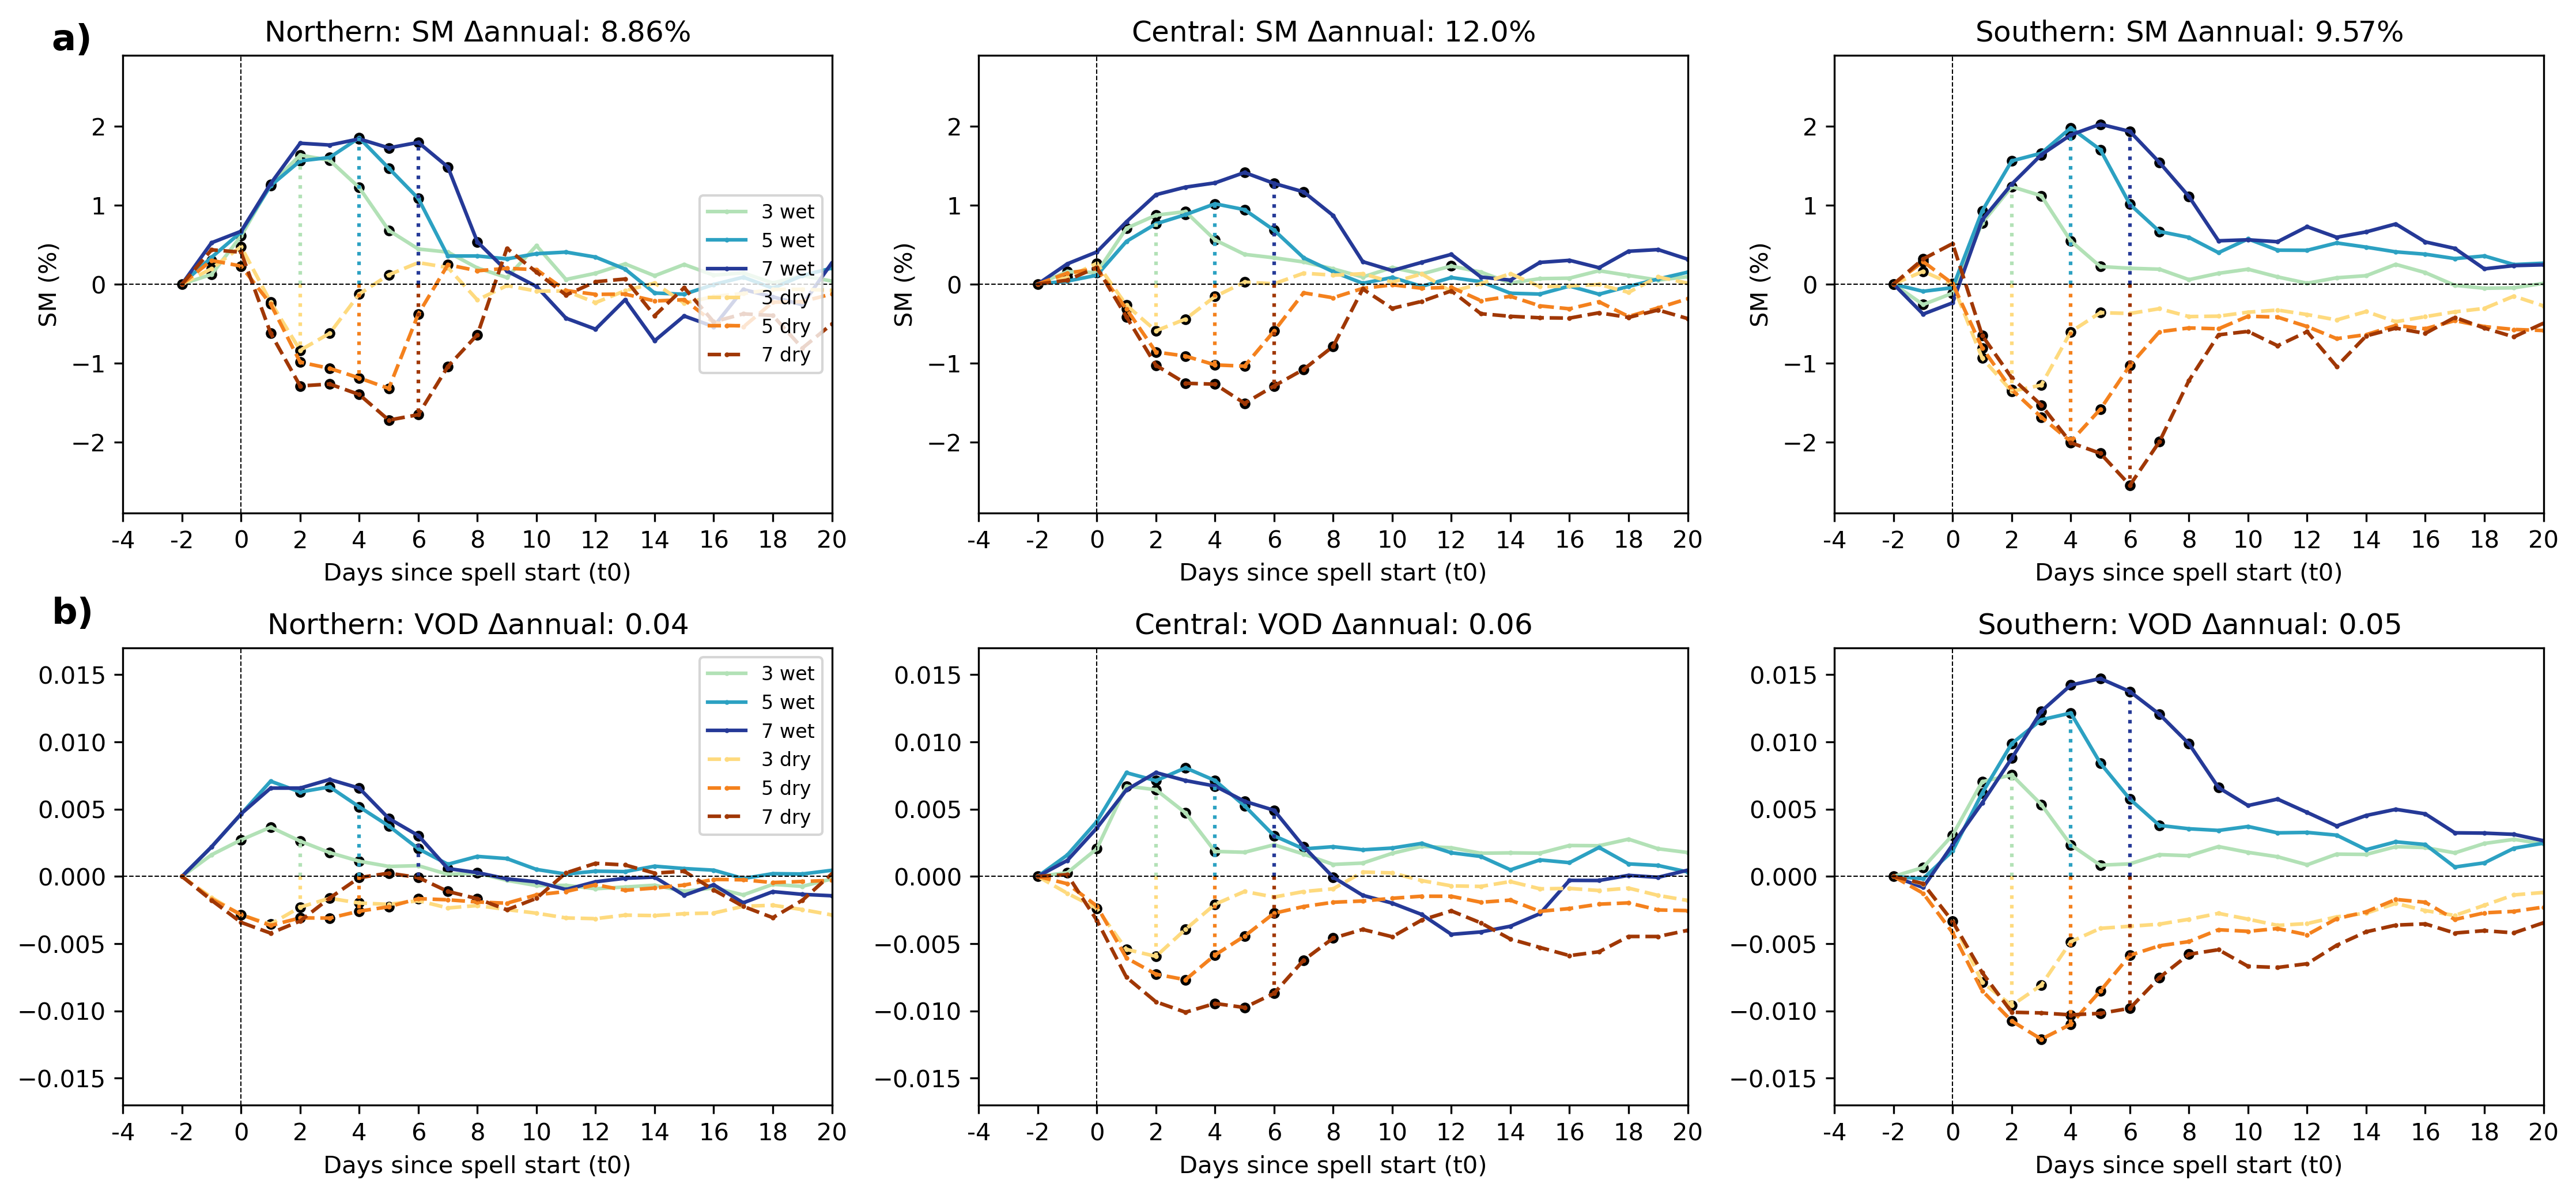

In [53]:
from matplotlib.lines import Line2D  
f = plt.figure(figsize=(15,7), dpi=300)

mv=1
cor_thresh = 0.05
p_thresh = 0.0001
ddays = np.arange(30)
maxday = 14


ax = f.add_subplot(231)
plt.plot(smw['3'][0], label='3 wet', marker='o', markersize=1, color=colorw[1])
plt.plot(smw['5'][0], label='5 wet', marker='o', markersize=1, color=colorw[3])
plt.plot(smw['7'][0], label='7 wet', marker='o', markersize=1, color=colorw[5])

for sp in [3,5,7]:
    days = np.arange(len(smw[str(sp)][0])) 
    m = (swcorr[str(sp)][0] > cor_thresh) & (swpval[str(sp)][0] < p_thresh)  & (ddays <= maxday)
    #m = swpval[str(sp)][0] < p_thresh
    ax.scatter(days[m], (smw[str(sp)][0])[m], color='k', s=12)

ax.plot(smd['3'][0], label='3 dry', marker='o', markersize=1, color=colord[1], linestyle='dashed')
ax.plot(smd['5'][0], label='5 dry', marker='o', markersize=1, color=colord[3], linestyle='dashed')
ax.plot(smd['7'][0], label='7 dry', marker='o', markersize=1, color=colord[5], linestyle='dashed')


for sp in [3,5,7]:
    days = np.arange(len(smd[str(sp)][0])) 
    m = (sdcorr[str(sp)][0] > cor_thresh) & (sdpval[str(sp)][0] < p_thresh)  & (ddays <= maxday)
    #m = sdpval[str(sp)][0] < p_thresh
    ax.scatter(days[m], (smd[str(sp)][0])[m], color='k', s=12)

plt.legend(fontsize=8, loc='right')
#plt.title('Northern: SM $\Delta$annual: '+str(np.round(smcollect['northern'].values*100,2))+"%")

plt.title('Northern: SM $\Delta$annual: '+str(np.round(smcollect['northern'].values*100,2))+"%")
plt.ylabel('SM (%)')
plt.xlabel('Days since spell start (t0)')

for sp, cc in zip([3,5,7],[1,3,5]):
    val = (smw[str(sp)][0])[sp+1]
    x = [sp+1,sp+1]
    y = [0,val]
    line = Line2D(x, y, color=colorw[cc], linestyle='dotted')
    ax.add_line(line)
    
    val = (smd[str(sp)][0])[sp+1]
    x = [sp+1,sp+1]
    y = [0,val]
    #y = [0,0.017]
    line = Line2D(x, y, color=colord[cc], linestyle='dotted')
    ax.add_line(line)

ax.axhline(0, linestyle='dashed', linewidth=0.5, color='k')
ax.set_ylim(-2.9,2.9)
ax.set_xlim(-2,21)

ax.set_xticks(np.arange(-2,23,2))
ax.set_xticklabels(np.arange(-2,23,2)-2)
ax.axvline(2, color='k', linewidth=0.5, linestyle='dashed')


# ax1 = ax.twinx()

# ax1.plot(pw['3'][0], label='3 wet', marker='o', markersize=1, color=colorw[1])
# ax1.plot(pw['5'][0], label='5 wet', marker='o', markersize=1, color=colorw[3])
# ax1.plot(pw['7'][0], label='7 wet', marker='o', markersize=1, color=colorw[5])

# ax1.plot(pd['3'][0], label='3 wet', marker='o', markersize=1, color=colorw[1])
# ax1.plot(pd['5'][0], label='5 wet', marker='o', markersize=1, color=colorw[3])
# ax1.plot(pd['7'][0], label='7 wet', marker='o', markersize=1, color=colorw[5])


ax = f.add_subplot(232)
ax.plot(smw['3'][1], label='3 wet', marker='o', markersize=1, color=colorw[1])
ax.plot(smw['5'][1], label='5 wet', marker='o', markersize=1, color=colorw[3])
ax.plot(smw['7'][1], label='7 wet', marker='o', markersize=1, color=colorw[5])


for sp in [3,5,7]:
    days = np.arange(len(smw[str(sp)][1])) 
    m = (swcorr[str(sp)][1] > cor_thresh) & (swpval[str(sp)][1] < p_thresh)  & (ddays <= maxday)  #
    ax.scatter(days[m], (smw[str(sp)][1])[m], color='k', s=12)

ax.plot(smd['3'][1], label='3 dry', marker='o', markersize=1, color=colord[1], linestyle='dashed')
ax.plot(smd['5'][1], label='5 dry', marker='o', markersize=1, color=colord[3], linestyle='dashed')
ax.plot(smd['7'][1], label='7 dry', marker='o', markersize=1, color=colord[5], linestyle='dashed')


for sp in [3,5,7]:
    days = np.arange(len(smd[str(sp)][1])) 
    m = (sdcorr[str(sp)][1] > cor_thresh) & (sdpval[str(sp)][1] < p_thresh)  & (ddays <= maxday)
    #m = sdpval[str(sp)][1] < p_thresh
    ax.scatter(days[m], (smd[str(sp)][1])[m], color='k', s=12)

plt.title('Central: SM $\Delta$annual: '+str(np.round(smcollect['central'].values,2)*100)+"%")
plt.ylabel('SM (%)')
plt.xlabel('Days since spell start (t0)')


for sp, cc in zip([3,5,7],[1,3,5]):
    val = (smw[str(sp)][1])[sp+1]
    x = [sp+1,sp+1]
    y = [0,val]
    line = Line2D(x, y, color=colorw[cc], linestyle='dotted')
    ax.add_line(line)
    
    val = (smd[str(sp)][1])[sp+1]
    x = [sp+1,sp+1]
    y = [0,val]
    #y = [0,0.017]
    line = Line2D(x, y, color=colord[cc], linestyle='dotted')
    ax.add_line(line)

ax.axhline(0, linestyle='dashed', linewidth=0.5, color='k')
ax.set_ylim(-2.9,2.9)
ax.set_xlim(-2,21)

ax.set_xticks(np.arange(-2,23,2))
ax.set_xticklabels(np.arange(-2,23,2)-2)
ax.axvline(2, color='k', linewidth=0.5, linestyle='dashed')


# ax1 = ax.twinx()
# ax1.plot(pw['3'][1], label='3 wet', marker='o', markersize=1, color=colorw[1])
# ax1.plot(pw['5'][1], label='5 wet', marker='o', markersize=1, color=colorw[3])
# ax1.plot(pw['7'][1], label='7 wet', marker='o', markersize=1, color=colorw[5])

# ax1.plot(pd['3'][1], label='3 wet', marker='o', markersize=1, color=colorw[1])
# ax1.plot(pd['5'][1], label='5 wet', marker='o', markersize=1, color=colorw[3])
# ax1.plot(pd['7'][1], label='7 wet', marker='o', markersize=1, color=colorw[5])



ax = f.add_subplot(233)
ax.plot(smw['3'][2], label='3 wet', marker='o', markersize=1, color=colorw[1])
ax.plot(smw['5'][2], label='5 wet', marker='o', markersize=1, color=colorw[3])
ax.plot(smw['7'][2], label='7 wet', marker='o', markersize=1, color=colorw[5])


for sp in [3,5,7]:
    days = np.arange(len(smw[str(sp)][2])) 
    m = (swcorr[str(sp)][2] > cor_thresh) & (swpval[str(sp)][2] < p_thresh)  & (ddays <= maxday)
    #m = swpval[str(sp)][2] < p_thresh
    ax.scatter(days[m], (smw[str(sp)][2])[m], color='k', s=12)

ax.plot(smd['3'][2], label='3 dry', marker='o', markersize=1, color=colord[1], linestyle='dashed')
ax.plot(smd['5'][2], label='5 dry', marker='o', markersize=1, color=colord[3], linestyle='dashed')
ax.plot(smd['7'][2], label='7 dry', marker='o', markersize=1, color=colord[5], linestyle='dashed')


for sp in [3,5,7]:
    days = np.arange(len(smd[str(sp)][2])) 
    m = (sdcorr[str(sp)][2] > cor_thresh) & (sdpval[str(sp)][2] < p_thresh)  & (ddays <= maxday)
    #m = sdpval[str(sp)][2] < p_thresh
    ax.scatter(days[m], (smd[str(sp)][2])[m], color='k', s=12)

plt.title('Southern: SM $\Delta$annual: '+str(np.round(smcollect['southern'].values*100,2))+"%")
plt.ylabel('SM (%)')
plt.xlabel('Days since spell start (t0)')

for sp, cc in zip([3,5,7],[1,3,5]):
    val = (smw[str(sp)][2])[sp+1]
    x = [sp+1,sp+1]
    y = [0,val]
    line = Line2D(x, y, color=colorw[cc], linestyle='dotted')
    ax.add_line(line)
    
    val = (smd[str(sp)][2])[sp+1]
    x = [sp+1,sp+1]
    y = [0,val]
    #y = [0,0.017]
    line = Line2D(x, y, color=colord[cc], linestyle='dotted')
    ax.add_line(line)

ax.axhline(0, linestyle='dashed', linewidth=0.5, color='k')
ax.set_ylim(-2.9,2.9)
ax.set_xlim(-2,21)

ax.set_xticks(np.arange(-2,23,2))
ax.set_xticklabels(np.arange(-2,23,2)-2)
ax.axvline(2, color='k', linewidth=0.5, linestyle='dashed')


# ax1 = ax.twinx()
# ax1.plot(pw['3'][2], label='3 wet', marker='o', markersize=1, color=colorw[1])
# ax1.plot(pw['5'][2], label='5 wet', marker='o', markersize=1, color=colorw[3])
# ax1.plot(pw['7'][2], label='7 wet', marker='o', markersize=1, color=colorw[5])

# ax1.plot(pd['3'][2], label='3 wet', marker='o', markersize=1, color=colorw[1])
# ax1.plot(pd['5'][2], label='5 wet', marker='o', markersize=1, color=colorw[3])
# ax1.plot(pd['7'][2], label='7 wet', marker='o', markersize=1, color=colorw[5])


#########################################
#########################################
cor_thresh = 0.05
p_thresh = 0.0001

ax = f.add_subplot(234)


plt.plot(vw['3'][0], label='3 wet', marker='o', markersize=1, color=colorw[1])
plt.plot(vw['5'][0], label='5 wet', marker='o', markersize=1, color=colorw[3])
plt.plot(vw['7'][0], label='7 wet', marker='o', markersize=1, color=colorw[5])

for sp in [3,5,7]:
    days = np.arange(len(vw[str(sp)][0])) 
    m = (vwcorr[str(sp)][0] > cor_thresh) & (vwpval[str(sp)][0] < p_thresh)
    plt.scatter(days[m], (vw[str(sp)][0])[m], color='k', s=12)

plt.plot(vd['3'][0], label='3 dry', marker='o', markersize=1, color=colord[1], linestyle='dashed')
plt.plot(vd['5'][0], label='5 dry', marker='o', markersize=1, color=colord[3], linestyle='dashed')
plt.plot(vd['7'][0], label='7 dry', marker='o', markersize=1, color=colord[5], linestyle='dashed')

for sp in [3,5,7]:
    days = np.arange(len(vd[str(sp)][0])) 
    m = (vdcorr[str(sp)][0] > cor_thresh) & (vdpval[str(sp)][0] < p_thresh)  & (ddays <= maxday)
    plt.scatter(days[m], (vd[str(sp)][0])[m], color='k', s=12)

plt.title('Northern: VOD $\Delta$annual: '+str(np.round(vodcollect['northern'].values,2))+"")
plt.ylabel('')
plt.xlabel('Days since spell start (t0)')
plt.legend(fontsize=8)


for sp, cc in zip([3,5,7],[1,3,5]):
    val = (vw[str(sp)][0])[sp+1]
    x = [sp+1,sp+1]
    y = [0,val]
    line = Line2D(x, y, color=colorw[cc], linestyle='dotted')
    ax.add_line(line)
    
    val = (vd[str(sp)][0])[sp+1]
    x = [sp+1,sp+1]
    y = [0,val]
    #y = [0,0.017]
    line = Line2D(x, y, color=colord[cc], linestyle='dotted')
    ax.add_line(line)

ax.axhline(0, linestyle='dashed', linewidth=0.5, color='k')
ax.set_ylim(-0.017,0.017)
ax.set_xlim(-2,21)

ax.set_xticks(np.arange(-2,23,2))
ax.set_xticklabels(np.arange(-2,23,2)-2)
ax.axvline(2, color='k', linewidth=0.5, linestyle='dashed')

ax = f.add_subplot(235)

# plt.plot(pw['7'][1]/1500, marker='o', markersize=1, color='k')
# plt.plot(pd['7'][1]/1500, marker='o', markersize=1, color='k')

plt.plot(vw['3'][1], label='3 wet', marker='o', markersize=1, color=colorw[1])
plt.plot(vw['5'][1], label='5 wet', marker='o', markersize=1, color=colorw[3])
plt.plot(vw['7'][1], label='7 wet', marker='o', markersize=1, color=colorw[5])

for sp in [3,5,7]:
    days = np.arange(len(vw[str(sp)][1])) 
    m = (vwcorr[str(sp)][1] > cor_thresh) & (vwpval[str(sp)][1] < p_thresh)
    plt.scatter(days[m], (vw[str(sp)][1])[m], color='k', s=12)

plt.plot(vd['3'][1], label='3 dry', marker='o', markersize=1, color=colord[1], linestyle='dashed')
plt.plot(vd['5'][1], label='5 dry', marker='o', markersize=1, color=colord[3], linestyle='dashed')
plt.plot(vd['7'][1], label='7 dry', marker='o', markersize=1, color=colord[5], linestyle='dashed')

for sp in [3,5,7]:
    days = np.arange(len(vd[str(sp)][1])) 
    m = (vdcorr[str(sp)][1] > cor_thresh) & (vdpval[str(sp)][1] < p_thresh)  & (ddays <= maxday)
    plt.scatter(days[m], (vd[str(sp)][1])[m], color='k', s=12)

plt.title('Central: VOD $\Delta$annual: '+str(np.round(vodcollect['central'].values,2))+"")
plt.ylabel('')
plt.xlabel('Days since spell start (t0)')


for sp, cc in zip([3,5,7],[1,3,5]):
    val = (vw[str(sp)][1])[sp+1]
    x = [sp+1,sp+1]
    y = [0,val]
    line = Line2D(x, y, color=colorw[cc], linestyle='dotted')
    ax.add_line(line)
    
    val = (vd[str(sp)][1])[sp+1]
    x = [sp+1,sp+1]
    y = [0,val]
    #y = [0,0.017]
    line = Line2D(x, y, color=colord[cc], linestyle='dotted')
    ax.add_line(line)

ax.axhline(0, linestyle='dashed', linewidth=0.5, color='k')
ax.set_ylim(-0.017,0.017)
ax.set_xlim(-2,21)

ax.set_xticks(np.arange(-2,23,2))
ax.set_xticklabels(np.arange(-2,23,2)-2)
ax.axvline(2, color='k', linewidth=0.5, linestyle='dashed')


ax = f.add_subplot(236)
plt.plot(vw['3'][2], label='3 wet', marker='o', markersize=1, color=colorw[1])
plt.plot(vw['5'][2], label='5 wet', marker='o', markersize=1, color=colorw[3])
plt.plot(vw['7'][2], label='7 wet', marker='o', markersize=1, color=colorw[5])

for sp in [3,5,7]:
    days = np.arange(len(vw[str(sp)][2])) 
    m = (vwcorr[str(sp)][2] > cor_thresh) & (vwpval[str(sp)][2] < p_thresh)
    plt.scatter(days[m], (vw[str(sp)][2])[m], color='k', s=12)

plt.plot(vd['3'][2], label='3 dry', marker='o', markersize=1, color=colord[1], linestyle='dashed')
plt.plot(vd['5'][2], label='5 dry', marker='o', markersize=1, color=colord[3], linestyle='dashed')
plt.plot(vd['7'][2], label='7 dry', marker='o', markersize=1, color=colord[5], linestyle='dashed')

for sp in [3,5,7]:
    days = np.arange(len(vd[str(sp)][2])) 
    m = (vdcorr[str(sp)][2] > cor_thresh) & (vdpval[str(sp)][2] < p_thresh)  & (ddays <= maxday)
    plt.scatter(days[m], (vd[str(sp)][2])[m], color='k', s=12)

plt.title('Southern: VOD $\Delta$annual: '+str(np.round(vodcollect['southern'].values,2))+"")
plt.ylabel('')
plt.xlabel('Days since spell start (t0)')



for sp, cc in zip([3,5,7],[1,3,5]):
    val = (vw[str(sp)][2])[sp+1]
    x = [sp+1,sp+1]
    y = [0,val]
    line = Line2D(x, y, color=colorw[cc], linestyle='dotted')
    ax.add_line(line)
    
    val = (vd[str(sp)][2])[sp+1]
    x = [sp+1,sp+1]
    y = [0,val]
    #y = [0,0.017]
    line = Line2D(x, y, color=colord[cc], linestyle='dotted')
    ax.add_line(line)

ax.axhline(0, linestyle='dashed', linewidth=0.5, color='k')
ax.set_ylim(-0.017,0.017)
ax.set_xlim(-2,21)

ax.set_xticks(np.arange(-2,23,2))
ax.set_xticklabels(np.arange(-2,23,2)-2)
ax.axvline(2, color='k', linewidth=0.5, linestyle='dashed')


################################################
################################################
plt.tight_layout()
plt.annotate('a)', xy=(0.02, 0.95), xytext=(0, 4), size=15, xycoords=('figure fraction', 'figure fraction'),
                 textcoords='offset points', fontweight='bold')
plt.annotate('b)', xy=(0.02, 0.47), xytext=(0, 4), size=15, xycoords=('figure fraction', 'figure fraction'),
                 textcoords='offset points', fontweight='bold')



f.savefig('/home/ck/DIR/cornkle/figs/HUARAZ/paper/sm_vod_timeseries_d-2startt_updatedmeanValclim.jpg')

In [23]:
sno = pd.read_csv('/home/ck/DIR/cornkle/data/HUARAZ/LORENZ_FigVOD/plot_data_Northern.csv')
sce = pd.read_csv('/home/ck/DIR/cornkle/data/HUARAZ/LORENZ_FigVOD/plot_data_Central.csv')
sso = pd.read_csv('/home/ck/DIR/cornkle/data/HUARAZ/LORENZ_FigVOD/plot_data_Southern.csv')

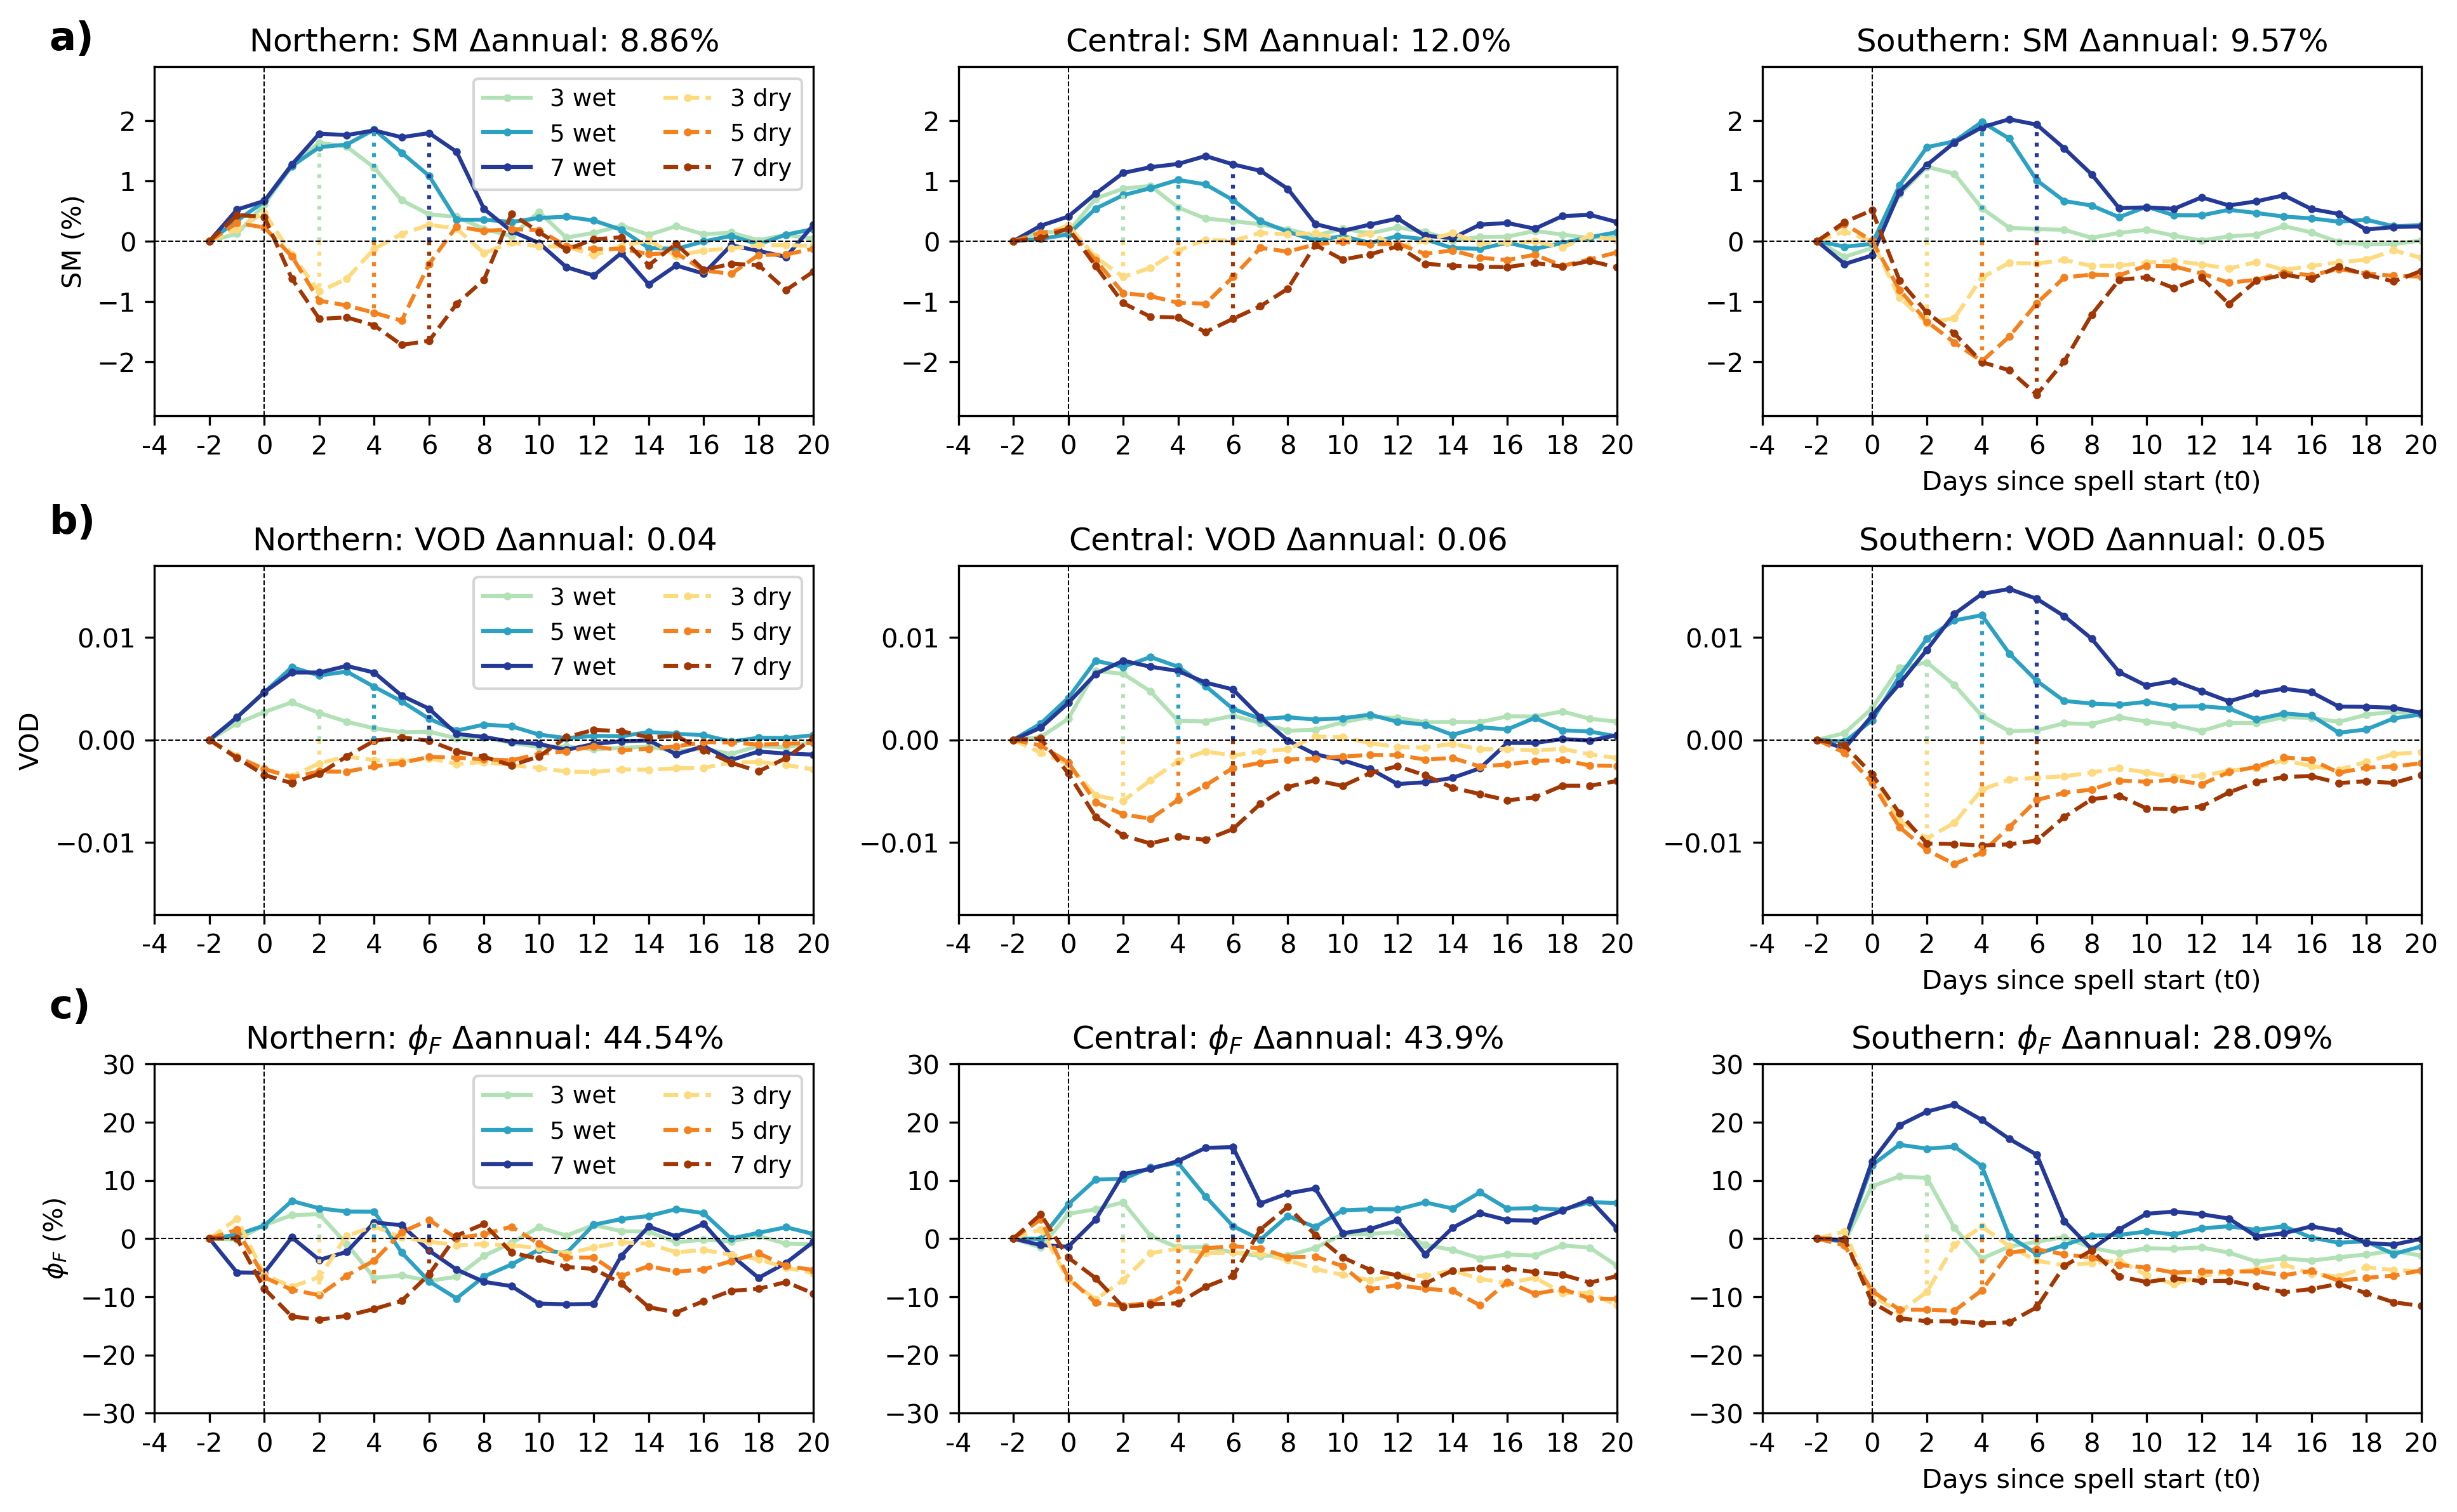

In [24]:
from matplotlib.lines import Line2D  
f = plt.figure(figsize=(13,8), dpi=300)

mv=1
cor_thresh = 0
p_thresh = 0.001

ax = f.add_subplot(331)
plt.plot(smw['3'][0], label='3 wet', marker='o', markersize=2, color=colorw[1])
plt.plot(smw['5'][0], label='5 wet', marker='o', markersize=2, color=colorw[3])
plt.plot(smw['7'][0], label='7 wet', marker='o', markersize=2, color=colorw[5])

ax.plot(smd['3'][0], label='3 dry', marker='o', markersize=2, color=colord[1], linestyle='dashed')
ax.plot(smd['5'][0], label='5 dry', marker='o', markersize=2, color=colord[3], linestyle='dashed')
ax.plot(smd['7'][0], label='7 dry', marker='o', markersize=2, color=colord[5], linestyle='dashed')

plt.legend(fontsize=9, loc='upper right', ncol=2)
plt.title('Northern: SM $\Delta$annual: '+str(np.round(smcollect['northern'].values*100,2))+"%")
plt.ylabel('SM (%)')
# plt.xlabel('Days since spell start (t0)')

for sp, cc in zip([3,5,7],[1,3,5]):
    val = (smw[str(sp)][0])[sp+1]
    x = [sp+1,sp+1]
    y = [0,val]
    line = Line2D(x, y, color=colorw[cc], linestyle='dotted')
    ax.add_line(line)
    
    val = (smd[str(sp)][0])[sp+1]
    x = [sp+1,sp+1]
    y = [0,val]
    #y = [0,0.017]
    line = Line2D(x, y, color=colord[cc], linestyle='dotted')
    ax.add_line(line)

ax.axhline(0, linestyle='dashed', linewidth=0.5, color='k')
ax.set_ylim(-2.9,2.9)
ax.set_xlim(-2,21)

ax.set_xticks(np.arange(-2,23,2))
ax.set_xticklabels(np.arange(-2,23,2)-2)
ax.axvline(2, color='k', linewidth=0.5, linestyle='dashed')


ax = f.add_subplot(332)
ax.plot(smw['3'][1], label='3 wet', marker='o', markersize=2, color=colorw[1])
ax.plot(smw['5'][1], label='5 wet', marker='o', markersize=2, color=colorw[3])
ax.plot(smw['7'][1], label='7 wet', marker='o', markersize=2, color=colorw[5])

ax.plot(smd['3'][1], label='3 dry', marker='o', markersize=2, color=colord[1], linestyle='dashed')
ax.plot(smd['5'][1], label='5 dry', marker='o', markersize=2, color=colord[3], linestyle='dashed')
ax.plot(smd['7'][1], label='7 dry', marker='o', markersize=2, color=colord[5], linestyle='dashed')

plt.title('Central: SM $\Delta$annual: '+str(np.round(smcollect['central'].values,2)*100)+"%")
# plt.ylabel('SM (%)')
# plt.xlabel('Days since spell start (t0)')


for sp, cc in zip([3,5,7],[1,3,5]):
    val = (smw[str(sp)][1])[sp+1]
    x = [sp+1,sp+1]
    y = [0,val]
    line = Line2D(x, y, color=colorw[cc], linestyle='dotted')
    ax.add_line(line)
    
    val = (smd[str(sp)][1])[sp+1]
    x = [sp+1,sp+1]
    y = [0,val]
    #y = [0,0.017]
    line = Line2D(x, y, color=colord[cc], linestyle='dotted')
    ax.add_line(line)

ax.axhline(0, linestyle='dashed', linewidth=0.5, color='k')
ax.set_ylim(-2.9,2.9)
ax.set_xlim(-2,21)

ax.set_xticks(np.arange(-2,23,2))
ax.set_xticklabels(np.arange(-2,23,2)-2)
ax.axvline(2, color='k', linewidth=0.5, linestyle='dashed')


ax = f.add_subplot(333)
ax.plot(smw['3'][2], label='3 wet', marker='o', markersize=2, color=colorw[1])
ax.plot(smw['5'][2], label='5 wet', marker='o', markersize=2, color=colorw[3])
ax.plot(smw['7'][2], label='7 wet', marker='o', markersize=2, color=colorw[5])

ax.plot(smd['3'][2], label='3 dry', marker='o', markersize=2, color=colord[1], linestyle='dashed')
ax.plot(smd['5'][2], label='5 dry', marker='o', markersize=2, color=colord[3], linestyle='dashed')
ax.plot(smd['7'][2], label='7 dry', marker='o', markersize=2, color=colord[5], linestyle='dashed')

plt.title('Southern: SM $\Delta$annual: '+str(np.round(smcollect['southern'].values*100,2))+"%")
# plt.ylabel('SM (%)')
plt.xlabel('Days since spell start (t0)')

for sp, cc in zip([3,5,7],[1,3,5]):
    val = (smw[str(sp)][2])[sp+1]
    x = [sp+1,sp+1]
    y = [0,val]
    line = Line2D(x, y, color=colorw[cc], linestyle='dotted')
    ax.add_line(line)
    
    val = (smd[str(sp)][2])[sp+1]
    x = [sp+1,sp+1]
    y = [0,val]
    #y = [0,0.017]
    line = Line2D(x, y, color=colord[cc], linestyle='dotted')
    ax.add_line(line)

ax.axhline(0, linestyle='dashed', linewidth=0.5, color='k')
ax.set_ylim(-2.9,2.9)
ax.set_xlim(-2,21)

ax.set_xticks(np.arange(-2,23,2))
ax.set_xticklabels(np.arange(-2,23,2)-2)
ax.axvline(2, color='k', linewidth=0.5, linestyle='dashed')



#########################################
#########################################

ax = f.add_subplot(334)


plt.plot(vw['3'][0], label='3 wet', marker='o', markersize=2, color=colorw[1])
plt.plot(vw['5'][0], label='5 wet', marker='o', markersize=2, color=colorw[3])
plt.plot(vw['7'][0], label='7 wet', marker='o', markersize=2, color=colorw[5])


plt.plot(vd['3'][0], label='3 dry', marker='o', markersize=2, color=colord[1], linestyle='dashed')
plt.plot(vd['5'][0], label='5 dry', marker='o', markersize=2, color=colord[3], linestyle='dashed')
plt.plot(vd['7'][0], label='7 dry', marker='o', markersize=2, color=colord[5], linestyle='dashed')

plt.title('Northern: VOD $\Delta$annual: '+str(np.round(vodcollect['northern'].values,2))+"")
plt.ylabel('VOD')
# plt.xlabel('Days since spell start (t0)')
plt.legend(fontsize=9, loc='upper right', ncol=2)


for sp, cc in zip([3,5,7],[1,3,5]):
    val = (vw[str(sp)][0])[sp+1]
    x = [sp+1,sp+1]
    y = [0,val]
    line = Line2D(x, y, color=colorw[cc], linestyle='dotted')
    ax.add_line(line)
    
    val = (vd[str(sp)][0])[sp+1]
    x = [sp+1,sp+1]
    y = [0,val]
    #y = [0,0.017]
    line = Line2D(x, y, color=colord[cc], linestyle='dotted')
    ax.add_line(line)

ax.axhline(0, linestyle='dashed', linewidth=0.5, color='k')
ax.set_ylim(-0.017,0.017)
ax.set_xlim(-2,21)

ax.set_xticks(np.arange(-2,23,2))
ax.set_xticklabels(np.arange(-2,23,2)-2)
ax.axvline(2, color='k', linewidth=0.5, linestyle='dashed')

ax = f.add_subplot(335)

plt.plot(vw['3'][1], label='3 wet', marker='o', markersize=2, color=colorw[1])
plt.plot(vw['5'][1], label='5 wet', marker='o', markersize=2, color=colorw[3])
plt.plot(vw['7'][1], label='7 wet', marker='o', markersize=2, color=colorw[5])

plt.plot(vd['3'][1], label='3 dry', marker='o', markersize=2, color=colord[1], linestyle='dashed')
plt.plot(vd['5'][1], label='5 dry', marker='o', markersize=2, color=colord[3], linestyle='dashed')
plt.plot(vd['7'][1], label='7 dry', marker='o', markersize=2, color=colord[5], linestyle='dashed')

plt.title('Central: VOD $\Delta$annual: '+str(np.round(vodcollect['central'].values,2))+"")
# plt.ylabel('VOD')
# plt.xlabel('Days since spell start (t0)')


for sp, cc in zip([3,5,7],[1,3,5]):
    val = (vw[str(sp)][1])[sp+1]
    x = [sp+1,sp+1]
    y = [0,val]
    line = Line2D(x, y, color=colorw[cc], linestyle='dotted')
    ax.add_line(line)
    
    val = (vd[str(sp)][1])[sp+1]
    x = [sp+1,sp+1]
    y = [0,val]
    #y = [0,0.017]
    line = Line2D(x, y, color=colord[cc], linestyle='dotted')
    ax.add_line(line)

ax.axhline(0, linestyle='dashed', linewidth=0.5, color='k')
ax.set_ylim(-0.017,0.017)
ax.set_xlim(-2,21)

ax.set_xticks(np.arange(-2,23,2))
ax.set_xticklabels(np.arange(-2,23,2)-2)
ax.axvline(2, color='k', linewidth=0.5, linestyle='dashed')


ax = f.add_subplot(336)
plt.plot(vw['3'][2], label='3 wet', marker='o', markersize=2, color=colorw[1])
plt.plot(vw['5'][2], label='5 wet', marker='o', markersize=2, color=colorw[3])
plt.plot(vw['7'][2], label='7 wet', marker='o', markersize=2, color=colorw[5])

plt.plot(vd['3'][2], label='3 dry', marker='o', markersize=2, color=colord[1], linestyle='dashed')
plt.plot(vd['5'][2], label='5 dry', marker='o', markersize=2, color=colord[3], linestyle='dashed')
plt.plot(vd['7'][2], label='7 dry', marker='o', markersize=2, color=colord[5], linestyle='dashed')

plt.title('Southern: VOD $\Delta$annual: '+str(np.round(vodcollect['southern'].values,2))+"")
# plt.ylabel('VOD')
plt.xlabel('Days since spell start (t0)')

for sp, cc in zip([3,5,7],[1,3,5]):
    val = (vw[str(sp)][2])[sp+1]
    x = [sp+1,sp+1]
    y = [0,val]
    line = Line2D(x, y, color=colorw[cc], linestyle='dotted')
    ax.add_line(line)
    
    val = (vd[str(sp)][2])[sp+1]
    x = [sp+1,sp+1]
    y = [0,val]
    #y = [0,0.017]
    line = Line2D(x, y, color=colord[cc], linestyle='dotted')
    ax.add_line(line)

ax.axhline(0, linestyle='dashed', linewidth=0.5, color='k')
ax.set_ylim(-0.017,0.017)
ax.set_xlim(-2,21)

ax.set_xticks(np.arange(-2,23,2))
ax.set_xticklabels(np.arange(-2,23,2)-2)
ax.axvline(2, color='k', linewidth=0.5, linestyle='dashed')



#######################################


ax = f.add_subplot(337)


plt.plot(sno['wet3']-sno['wet3'][0], label='3 wet', marker='o', markersize=2, color=colorw[1])
plt.plot(sno['wet5']-sno['wet5'][0], label='5 wet', marker='o', markersize=2, color=colorw[3])
plt.plot(sno['wet7']-sno['wet7'][0], label='7 wet', marker='o', markersize=2, color=colorw[5])


plt.plot(sno['dry3']-sno['dry3'][0], label='3 dry', marker='o', markersize=2, color=colord[1], linestyle='dashed')
plt.plot(sno['dry5']-sno['dry5'][0], label='5 dry', marker='o', markersize=2, color=colord[3], linestyle='dashed')
plt.plot(sno['dry7']-sno['dry7'][0], label='7 dry', marker='o', markersize=2, color=colord[5], linestyle='dashed')

plt.title('Northern: $\phi _F$ $\Delta$annual: 44.54%')
plt.ylabel('$\phi _F$ (%)')
# plt.xlabel('Days since spell start (t0)')
ax.legend(fontsize=9, loc='upper right', ncol=2)


for sp, cc in zip([3,5,7],[1,3,5]):
    val = (sno['wet'+str(sp)])[sp+1]
    x = [sp+1,sp+1]
    y = [0,val]
    line = Line2D(x, y, color=colorw[cc], linestyle='dotted')
    ax.add_line(line)
    
    val = (sno['dry'+str(sp)])[sp+1]
    x = [sp+1,sp+1]
    y = [0,val]
    #y = [0,0.017]
    line = Line2D(x, y, color=colord[cc], linestyle='dotted')
    ax.add_line(line)

ax.axhline(0, linestyle='dashed', linewidth=0.5, color='k')
ax.set_ylim(-30,30)
ax.set_xlim(-2,21)

ax.set_xticks(np.arange(-2,23,2))
ax.set_xticklabels(np.arange(-2,23,2)-2)
ax.axvline(2, color='k', linewidth=0.5, linestyle='dashed')

ax = f.add_subplot(338)

plt.plot(sce['wet3']-sce['wet3'][0], label='3 wet', marker='o', markersize=2, color=colorw[1])
plt.plot(sce['wet5']-sce['wet5'][0], label='5 wet', marker='o', markersize=2, color=colorw[3])
plt.plot(sce['wet7']-sce['wet7'][0], label='7 wet', marker='o', markersize=2, color=colorw[5])

plt.plot(sce['dry3']-sce['dry3'][0], label='3 dry', marker='o', markersize=2, color=colord[1], linestyle='dashed')
plt.plot(sce['dry5']-sce['dry5'][0], label='5 dry', marker='o', markersize=2, color=colord[3], linestyle='dashed')
plt.plot(sce['dry7']-sce['dry7'][0], label='7 dry', marker='o', markersize=2, color=colord[5], linestyle='dashed')

plt.title('Central: $\phi _F$ $\Delta$annual: 43.9%')
# plt.ylabel('$\phi _F$ (%)')
# plt.xlabel('Days since spell start (t0)')


for sp, cc in zip([3,5,7],[1,3,5]):
    val = (sce['wet'+str(sp)]-sce['wet'+str(sp)][0])[sp+1]
    x = [sp+1,sp+1]
    y = [0,val]
    line = Line2D(x, y, color=colorw[cc], linestyle='dotted')
    ax.add_line(line)
    
    val = (sce['dry'+str(sp)]-sce['dry'+str(sp)][0])[sp+1]
    x = [sp+1,sp+1]
    y = [0,val]
    #y = [0,0.017]
    line = Line2D(x, y, color=colord[cc], linestyle='dotted')
    ax.add_line(line)

ax.axhline(0, linestyle='dashed', linewidth=0.5, color='k')
ax.set_ylim(-30,30)
ax.set_xlim(-2,21)

ax.set_xticks(np.arange(-2,23,2))
ax.set_xticklabels(np.arange(-2,23,2)-2)
ax.axvline(2, color='k', linewidth=0.5, linestyle='dashed')


ax = f.add_subplot(339)
plt.plot(sso['wet3']-sso['wet3'][0], label='3 wet', marker='o', markersize=2, color=colorw[1])
plt.plot(sso['wet5']-sso['wet5'][0], label='5 wet', marker='o', markersize=2, color=colorw[3])
plt.plot(sso['wet7']-sso['wet7'][0], label='7 wet', marker='o', markersize=2, color=colorw[5])

plt.plot(sso['dry3']-sso['dry3'][0], label='3 dry', marker='o', markersize=2, color=colord[1], linestyle='dashed')
plt.plot(sso['dry5']-sso['dry5'][0], label='5 dry', marker='o', markersize=2, color=colord[3], linestyle='dashed')
plt.plot(sso['dry7']-sso['dry7'][0], label='7 dry', marker='o', markersize=2, color=colord[5], linestyle='dashed')

plt.title('Southern: $\phi _F$ $\Delta$annual: 28.09%')
# plt.ylabel('$\phi _F$ (%)')
plt.xlabel('Days since spell start (t0)')

for sp, cc in zip([3,5,7],[1,3,5]):
    val = (sso['wet'+str(sp)]-sso['wet'+str(sp)][0])[sp+1]
    x = [sp+1,sp+1]
    y = [0,val]
    line = Line2D(x, y, color=colorw[cc], linestyle='dotted')
    ax.add_line(line)
    
    val = (sso['dry'+str(sp)]-sso['dry'+str(sp)][0])[sp+1]
    x = [sp+1,sp+1]
    y = [0,val]
    #y = [0,0.017]
    line = Line2D(x, y, color=colord[cc], linestyle='dotted')
    ax.add_line(line)

ax.axhline(0, linestyle='dashed', linewidth=0.5, color='k')
ax.set_ylim(-30,30)
ax.set_xlim(-2,21)

ax.set_xticks(np.arange(-2,23,2))
ax.set_xticklabels(np.arange(-2,23,2)-2)
ax.axvline(2, color='k', linewidth=0.5, linestyle='dashed')


################################################
################################################
plt.tight_layout()
plt.annotate('a)', xy=(0.02, 0.96), xytext=(0, 4), size=15, xycoords=('figure fraction', 'figure fraction'),
                 textcoords='offset points', fontweight='bold')
plt.annotate('b)', xy=(0.02, 0.64), xytext=(0, 4), size=15, xycoords=('figure fraction', 'figure fraction'),
                 textcoords='offset points', fontweight='bold')
plt.annotate('c)', xy=(0.02, 0.32), xytext=(0, 4), size=15, xycoords=('figure fraction', 'figure fraction'),
                 textcoords='offset points', fontweight='bold')



f.savefig('/home/ck/DIR/cornkle/figs/HUARAZ/paper/eps/sm_vod_phi_timeseries_d-2startt.pdf')

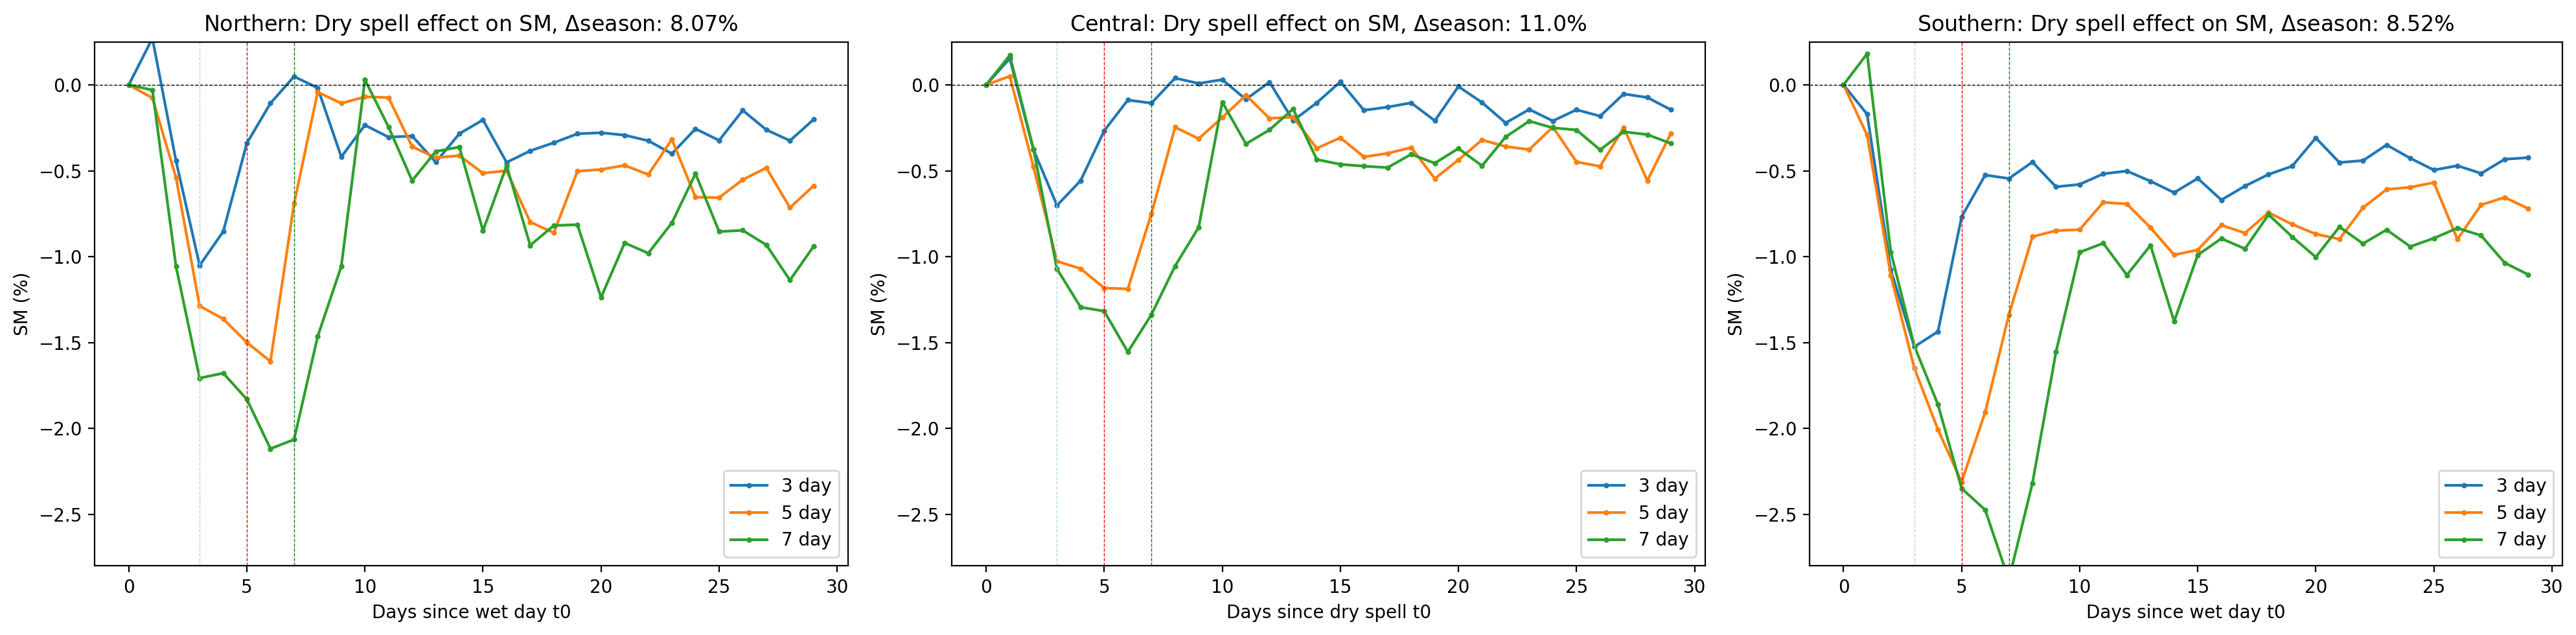

In [52]:
f = plt.figure(figsize=(20,5), dpi=200)

mv=1

ax = f.add_subplot(131)
plt.plot(smd['3'][0], label='3 day', marker='o', markersize=2)
plt.plot(smd['5'][0], label='5 day', marker='o', markersize=2)
plt.plot(smd['7'][0], label='7 day', marker='o', markersize=2)
plt.legend()
plt.title('Northern: Dry spell effect on SM, $\Delta$season: '+str(np.round(smcollect['northern'].values*100,2))+"%")
plt.ylabel('SM (%)')
plt.xlabel('Days since wet day t0')
ax.axvline(3, linestyle='dashed', linewidth=0.5, color='lightblue')
ax.axvline(5, linestyle='dashed', linewidth=0.5, color='red')
ax.axvline(7, linestyle='dashed', linewidth=0.5, color='green')
ax.axhline(0, linestyle='dashed', linewidth=0.5, color='k')
ax.set_ylim(-2.8,0.25)
#plt.savefig('/home/ck/DIR/cornkle/figs/HUARAZ/paper/sm_northern_testv2.jpg')

ax = f.add_subplot(132)
plt.plot(smd['3'][1], label='3 day', marker='o', markersize=2)
plt.plot(smd['5'][1], label='5 day', marker='o', markersize=2)
plt.plot(smd['7'][1], label='7 day', marker='o', markersize=2)
plt.legend()
plt.title('Central: Dry spell effect on SM, $\Delta$season: '+str(np.round(smcollect['central'].values,2)*100)+"%")
plt.ylabel('SM (%)')
plt.xlabel('Days since dry spell t0')
ax.axvline(3, linestyle='dashed', linewidth=0.5, color='lightblue')
ax.axvline(5, linestyle='dashed', linewidth=0.5, color='red')
ax.axvline(7, linestyle='dashed', linewidth=0.5, color='green')
ax.axhline(0, linestyle='dashed', linewidth=0.5, color='k')
ax.set_ylim(-2.8,0.25)
#plt.savefig('/home/ck/DIR/cornkle/figs/HUARAZ/paper/sm_central_testv2.jpg')

ax = f.add_subplot(133)
plt.plot(smd['3'][2], label='3 day', marker='o', markersize=2)
plt.plot(smd['5'][2], label='5 day', marker='o', markersize=2)
plt.plot(smd['7'][2], label='7 day', marker='o', markersize=2)
plt.legend()
plt.title('Southern: Dry spell effect on SM, $\Delta$season: '+str(np.round(smcollect['southern'].values*100,2))+"%")
plt.ylabel('SM (%)')
plt.xlabel('Days since wet day t0')
ax.axvline(3, linestyle='dashed', linewidth=0.5, color='lightblue')
ax.axvline(5, linestyle='dashed', linewidth=0.5, color='red')
ax.axvline(7, linestyle='dashed', linewidth=0.5, color='green')
ax.axhline(0, linestyle='dashed', linewidth=0.5, color='k')
ax.set_ylim(-2.8,0.25)

plt.tight_layout()